###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 1: Music genre classification with naive Bayes


**Student ID(s):**     1223465


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [1666]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing
import pandas as pd
import numpy as np
from math import sqrt, pi, exp, log
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns


def preprocess(data):
    
    scaler = MinMaxScaler()
    le = LabelEncoder()
    
    data = data.copy()
    data.loc[:, "label"] = le.fit_transform(data["label"])
    
    # Dropping irrelevant columns
    data = data.drop(["filename", "chroma_stft_mean", "chroma_stft_var", "rms_mean", "rms_var", "zero_crossing_rate_mean"
                     , "zero_crossing_rate_var", "harmony_mean", "harmony_var", "perceptr_mean", "perceptr_var", "tempo"], axis=1)

    
    #Min-Max scaling of data
    scaler.fit(data.iloc[:, :-1])
    scaled_data = scaler.transform(data.iloc[:, :-1])
    scaled_df = pd.DataFrame(scaled_data, columns=data.iloc[:, :-1].columns)
    scaled_df = pd.concat([scaled_df, data["label"]], axis=1)
    
    #rounding data
    scaled_df = data.round(5)
    data = scaled_df
    return data

In [1667]:
# This function should calculat prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def train(data):
    
    #Calculating priors
    priors = {}
    n = len(data["label"])
    for i in data["label"].unique():
        priors[i] = log(sum(data["label"] == i)/n)
    #print(priors)
    
    #Calculating likelihoods of each subset of class labels
    class_subsets = []
    for i in data["label"].unique():
        subset = data[data['label'] == i]
        class_subsets.append(subset.iloc[:, :-1])
    #print(class_subsets[0])
    
    # Calculating means and variances for each columns in subsets 
    means = [round(np.mean(subset, axis=0), 5) for subset in class_subsets]
    variances = [round(np.var(subset, axis=0), 5) for subset in class_subsets]
    
    # To avoid small variance values to avoid division by zero error
    variances = np.where(np.abs(variances) < 1e-4, 1/len(data), variances)
    
    # calculating post prob of each instance
    post_prob = []
    n_missing = 0
    for subset in range(0, len(class_subsets)):
        prob = []
        for row in range(0, len(class_subsets[subset])):
            likelihood = 0
            for columns in range(0, len(data.columns)-1):
                #checking for missing values 
                if class_subsets[subset].iloc[row, :][columns] == 0:
                    n_missing += 1
                    continue
                #applying log transformation of avoid small values
                else:
                    likelihood += log(pdf(n, class_subsets[subset].iloc[row, :][columns], means[subset][columns], variances[subset][columns]))
                        
            likelihood = round(priors[subset] + likelihood , 5)
            prob.append(likelihood)
            post_prob.append(likelihood)
        class_subsets[subset]["Posterior Probability"] = prob
        
    data["posterior"] = post_prob
    #print(f"Total missing values: {n_missing}")
    # calculating max posterior probability of each class subsets
    argmax = {}
    for i in range(0, len(class_subsets)):
        argmax[i] = class_subsets[i]["Posterior Probability"].max()

        
    return argmax, data

# Probability density function
def pdf(n, x, mu, sd):
    #laplace smoothing of 0.5 to every value
    value = (1 / (sd * sqrt(2 * pi))) * exp(-0.5 * ((float(x) - mu) / sd) ** 2) + 0.5
    if value < 1e-4:
        value = 0.5
    return value

In [1668]:
# This function should predict classes for new items in a test dataset

def predict(argmax, df, argmax_t, df_t):
    #training both train and test datasets
    
    # After calculating argmax on trained dataset.
    # Maps each instance of test set based on closest argmax value.
    pred_class=[]
    for value in df_t["posterior"]:
        closest_num = None
        closest_dist = float('inf')
        for num in argmax.values():
            dist = abs(num - value)
            if dist < closest_dist:
                closest_dist = dist
                closest_num = num
        pred_class.append(get_keys(argmax,closest_num))
        
        #print(f"posterior, {value} is closest to {get_keys(argmax,closest_num)} class label")
    
    df_t["predicted class"] = pd.DataFrame(pred_class)
    #print(df_t[["label", "predicted class"]])

    return df_t

def get_keys(d, value):
    key = [k for k, v in d.items() if v == value]
    return key[0]

In [1669]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate():
    data = pd.read_csv("COMP30027_2023_asst1_data 2/gztan_train.csv")
    test_df = pd.read_csv("COMP30027_2023_asst1_data 2/gztan_test.csv")
    
    # Create heatmap
    #corr_matrix = data.corr()
    #sns.heatmap(corr_matrix, annot=False)
    #plt.title("Correlation Plot")
    #plt.savefig('Correlation_plot.png')
    #plt.show()

    # Evaluating model
    data = preprocess(data)
    test_df = preprocess(test_df)
    argmax, data = train(data)
    argmax_t, test_df = train(test_df)
    model = predict(argmax, data,argmax_t, test_df)
    
    #Create confusion matrix
    #cm = confusion_matrix(model["label"], model["predicted class"])   
    #fig, ax = plt.subplots(figsize=(8, 6))
    #sns.heatmap(cm, annot=True, fmt='d', xticklabels=model["label"].unique(), yticklabels=model["predicted class"].unique(), cmap='Blues')
    #ax.set_xlabel('Predicted Labels')
    #ax.set_ylabel('True Labels')
    #plt.savefig('confustion_matrix.png')
    #plt.show()

    
    acc1 = accuracy_score(model["label"], model["predicted class"])
    print("Accuracy of model on gztan_test dataset:", acc1)
    return acc1
evaluate()

Accuracy of model on gztan_test dataset: 0.29


0.29

## Task 1. Pop vs. classical music classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q1
Compute and report the accuracy, precision, and recall of your model (treat "classical" as the "positive" class).

Overall performance of the model on pop_vs_classical_test dataset 


Confusion Matrix
 [[20  0]
 [ 1 22]]

Accuracy =  0.977
Precision =  1.0
Recall =  0.957


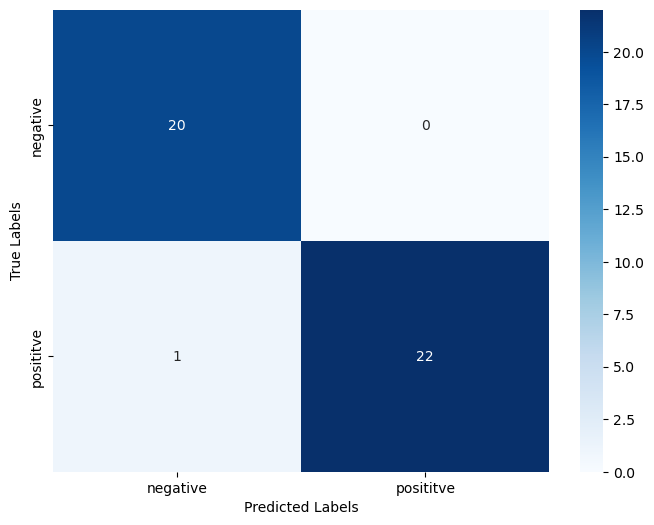

In [1670]:
data2 = pd.read_csv("COMP30027_2023_asst1_data 2/pop_vs_classical_train.csv")
test_df2 = pd.read_csv("COMP30027_2023_asst1_data 2/pop_vs_classical_test.csv")

data2 = preprocess(data2)
test_df2 = preprocess(test_df2)
argmax, df = train(data2)
argmax_t, df_t = train(test_df2)
model = predict(argmax, df, argmax_t, df_t)

true_label = model["label"]
pred_label = model["predicted class"]

# label encoder assigns 0 to classical and 1 to pop genre, converting into postive/negative classes.
model["label"] = ["negative" if label == 0 else "posititve" for label in model["label"]]
model["predicted class"] = ["negative" if label == 0 else "posititve" for label in model["predicted class"]]
#print(pd.DataFrame(zip(model["label"], model["predicted class"])))

#calculating confusion matrix, accuracy, precision and recall of the model
cm = confusion_matrix(true_label, pred_label)
acc = round(accuracy_score(true_label, pred_label), 3)
precision = round(precision_score(true_label, pred_label), 3)
recall = round(recall_score(true_label, pred_label), 3)

print("Overall performance of the model on pop_vs_classical_test dataset \n\n")
print("Confusion Matrix\n", cm)
print("\nAccuracy = ", acc)
print("Precision = ", precision)
print("Recall = ", recall)

#plotting confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=model["label"].unique(), yticklabels=model["predicted class"].unique(), cmap='Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.savefig('pop_vs_classical_confustion_matrix.png')
plt.show()

'''Accuracy:  0.699656188605108
Precision:  0.40191478500754835
Recall:  0.3462783418852154
F1-score:  0.31250028840252686
'''

### Q2
For each of the features X below, plot the probability density functions P(X|Class = pop) and P(X|Class = classical). If you had to classify pop vs. classical music using just one of these three features, which feature would you use and why? Refer to your plots to support your answer.
- spectral centroid mean
- harmony mean
- tempo

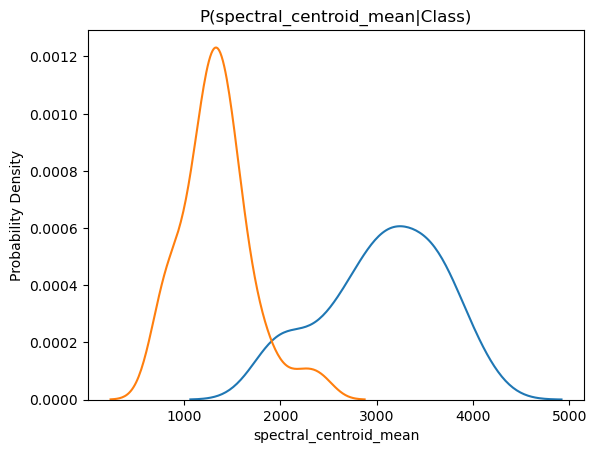

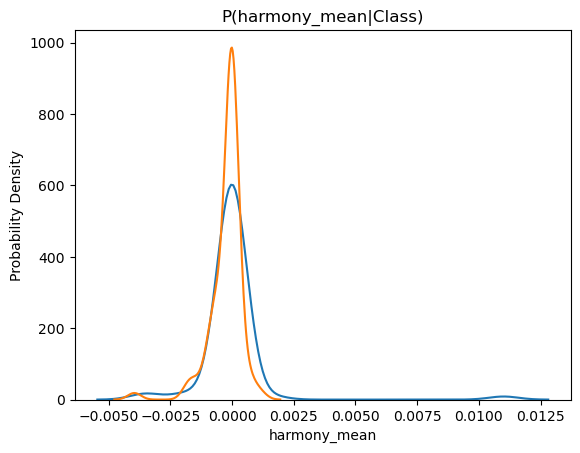

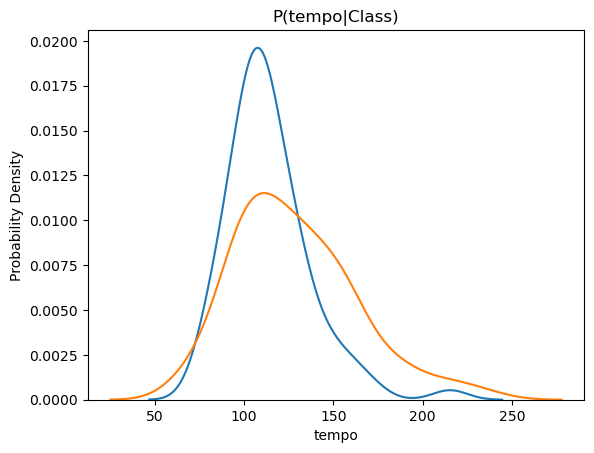

In [1671]:
data = pd.read_csv("COMP30027_2023_asst1_data 2/pop_vs_classical_train.csv")

pop_data = data[data['label'] == 'pop']
classical_data = data[data['label'] == 'classical']

for feature in ['spectral_centroid_mean', 'harmony_mean', 'tempo']:
    sns.kdeplot(pop_data[feature], label='Pop')
    sns.kdeplot(classical_data[feature], label='Classical')
    plt.xlabel(feature)
    plt.ylabel('Probability Density')
    plt.title('P({}|Class)'.format(feature))
    plt.savefig('prob_deensity_{}.png'.format(feature))
    plt.show()

#Create heatmap
#data = data[['spectral_centroid_mean', 'harmony_mean', 'tempo']]
#corr_matrix = data.corr()
#sns.heatmap(corr_matrix, annot=True, cmap = "Reds")
#plt.title("Correlation Plot")
#plt.savefig('Correlation_plot2.png')
#plt.show()

## Task 2. 10-way music genre classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q6
Modify your naive Bayes model to handle missing attributes in the test data. Recall from lecture that you can handle missing attributes at test by skipping the missing attributes and computing the posterior probability from the non-missing attributes. Randomly delete some attributes from the provided test set to test how robust your model is to missing data. In your write-up, evaluate how your model's performance changes as the amount of missing data increases.

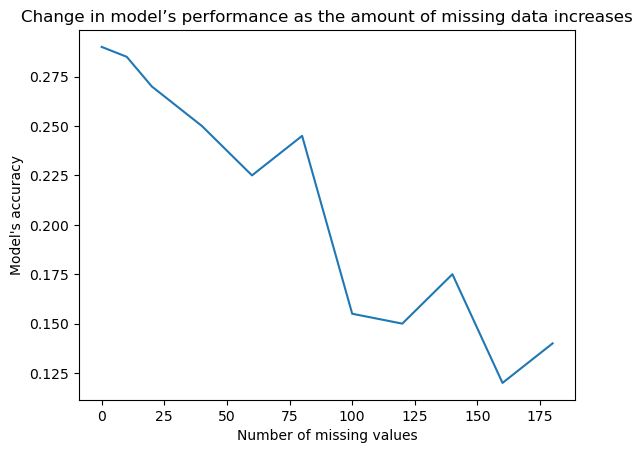

In [1673]:
data = pd.read_csv("COMP30027_2023_asst1_data 2/gztan_train.csv")
test_data = pd.read_csv("COMP30027_2023_asst1_data 2/gztan_test.csv")

n_delete = [0, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180]
acc_array = []

data = preprocess(data)
test_data = preprocess(test_data)
argmax, data = train(data)


for num in n_delete:
    test_data_c = test_data.copy()
    
    #chooses random columns from the data
    col_idx = np.random.choice(test_data.shape[1])
    col = test_data.iloc[:, col_idx]
    
    #chooses random indexes in that column to delete
    delete_idx = np.random.choice(col.shape[0], size=num, replace=False)
    col_mod = col.copy()
    col_mod[delete_idx] = 0
    col_mod = pd.DataFrame(col_mod)
    
    test_data_c.iloc[:, col_idx] = col_mod
    #zero_values = test_data_c.loc[(test_data_c == 0).any(axis=1), (test_data_c == 0).any(axis=0)]
    #print(zero_values)
    
    argmax_t, test_df = train(test_data_c)
    model = predict(argmax, data,argmax_t, test_df)
    
    true_label = model["label"]
    pred_label = model["predicted class"]
    
    acc = accuracy_score(true_label, pred_label)
    acc_array.append(acc)
    

    
plt.plot(n_delete, acc_array)
plt.xlabel('Number of missing values')
plt.ylabel("Model's accuracy")
plt.title('Change in model’s performance as the amount of missing data increases')
plt.savefig('accuracy_missing.png')
plt.show()

